***Project Owner : Sujay Torvi , Email me at sujay.torvi@gmail.com
Copyright © 2019***

# AI Capstone Project
## Domain: Retail
## Problem Statement

***Demand Forecast is one of the key tasks in Supply Chain and Retail Domain in general. It is key in effective operation and optimization of retail supply chain. Effectively solving this problem requires knowledge about a wide range of tricks in Data Sciences and good understanding of ensemble techniques.***
***You are required to predict sales for each Store-Day level for one month. All the features will be provided and actual sales that happened during that month will also be provided for model evaluation.***

## Agenda for Week 3
### Implementing Neural Networks & Unsupervised Learning
### 1.Train a LSTM on the same set of features and compare the result with traditional time-series model.
### 2. Comment on the behavior of all the models you have built so far
### 3 Cluster stores using sales and customer visits as features. Find out how many clusters or groups are possible. Also visualize the results.
### 4. Is it possible to have separate prediction models for each cluster? Compare results with the previous models.

In [0]:
#Import libraries

In [0]:
#from google.colab import files
#w = files.upload()

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

### ***Time Series using LSTM***

### Here we will first average sales for all the store for all days and then we will use LSTM on the averaged data. Data will be standardized to reduce computation costs.

In [0]:
train = pd.read_csv('train_data.csv')

In [0]:
test  = pd.read_csv('test_data_hidden.csv')

In [0]:
train = train[['Date','Sales']]
test = test[['Date','Sales']]

In [0]:
train = train.groupby('Date').mean().reset_index()
test = test.groupby('Date').mean().reset_index()

In [0]:
train = train.set_index('Date')
test = test.set_index('Date')

In [0]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [0]:
newtrain = train
newtest = test

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(np.asarray(train).reshape(-1,1))
test = sc.fit_transform(np.asarray(test).reshape(-1,1))

### Data Will be fed to the LSTMs in groups of 30 Timesteps. According to the given data the trend is varying monthly hence the LSTMs will calculate the sales given the window of previous 30 days.[Also beyond 30 days the LSTMs will forget the sales data].We will be later averaging the sales i.e summing all the sales in a given month and grouping the monthly sales which will be displayed in the plot.

In [0]:
X_train = []
y_train = []
for i in range(30, 911):
    X_train.append(train[i-30:i, 0])
    y_train.append(train[i, 0])

In [0]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
from tensorflow import keras

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
regressor = Sequential()

In [0]:
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [0]:
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [0]:
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

In [0]:
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

In [0]:
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

In [0]:
regressor.add(Dense(units = 1))

In [0]:
regressor.compile(optimizer = 'adagrad', loss = 'mean_squared_error')

In [0]:
with tf.device('/GPU:0'):
  regressor.fit(X_train, y_train, epochs = 100, batch_size = 720)

Train on 881 samples
Epoch 1/100
881/881 [==============================] - 11s 12ms/sample - loss: 0.2077
Epoch 2/100
881/881 [==============================] - 0s 407us/sample - loss: 0.1180
Epoch 3/100
881/881 [==============================] - 0s 428us/sample - loss: 0.0534
Epoch 4/100
881/881 [==============================] - 0s 459us/sample - loss: 0.0448
Epoch 5/100
881/881 [==============================] - 0s 403us/sample - loss: 0.0488
Epoch 6/100
881/881 [==============================] - 0s 403us/sample - loss: 0.0456
Epoch 7/100
881/881 [==============================] - 0s 446us/sample - loss: 0.0447
Epoch 8/100
881/881 [==============================] - 0s 471us/sample - loss: 0.0456
Epoch 9/100
881/881 [==============================] - 0s 459us/sample - loss: 0.0473
Epoch 10/100
881/881 [==============================] - 0s 422us/sample - loss: 0.0452
Epoch 11/100
881/881 [==============================] - 0s 405us/sample - loss: 0.0458
Epoch 12/100
881/881 [=========

In [0]:
data = pd.concat((newtrain, newtest), axis = 0)

In [0]:
inputs = data.values

In [0]:
inputs = inputs.reshape(-1,1)

In [0]:
inputs = sc.transform(inputs) # Transform input back to orignal values

In [0]:
X_test = []

In [0]:
for i in range(30, 942):
    X_test.append(inputs[i-30:i, 0])

In [0]:
X_test = np.asarray(X_test)

In [0]:
X_test.shape

(912, 30)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
sales_prediction = regressor.predict(X_test)

In [0]:
sales_prediction = sc.inverse_transform(sales_prediction)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [0]:
newdata = data.tail(912)
pred = pd.DataFrame(sales_prediction,index = newdata.index)

In [0]:
sqrt(mean_squared_error(pred.values, newdata.values))

2926.0218040675086

In [0]:
monthdata = data.resample('MS').sum()

In [0]:
monthpred = pred.tail(911).resample('MS').sum()

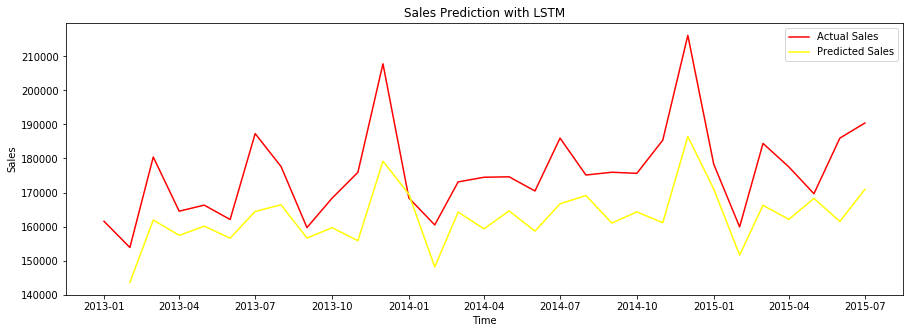

In [0]:
plt.figure(figsize=(15,5))
plt.plot(monthdata, color = 'red', label = 'Actual Sales')
plt.plot(monthpred, color = 'yellow', label = 'Predicted Sales')
plt.title('Sales Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
#plt.ylim(1500,11000)
plt.legend()
plt.show()

### From above graph we can see the LSTM has neatly fit the data while not overfitting it.

In [0]:
print('RMSE = {}'.format(sqrt(mean_squared_error(monthpred.values, monthdata.tail(30).values))))

RMSE = 15412.975519965148


In [0]:
print('MAE = {}'.format(mean_absolute_error(monthpred.values, monthdata.tail(30).values)))

MAE = 13381.805757900487


In [0]:
#For the test data:
print('For [2015-07]:\nActual = {} & Predicted = {}'.format(monthdata.tail(1).values[0],monthpred.tail(1).values[0]))

For [2015-07]:
Actual = [190423.87085202] & Predicted = [170939.02]


**Lets Draw A Comparision**

***Week 2 Results:***

| Model | RMSE | MAE |
| --- | --- | -- |
| ARIMA| 25460.47 | 18051.20|

***Week 3 Results:***

| Model | RMSE| MAE|
| --- | --- | --- |
| LSTM[30 day timestep]| 190423 | 170939 

### As we can see the LSTMs are performing better than the standard ARIMA Time series model, the ARIMA model was trained on monthly data wheras LSTMs were train on day wise data. This was necessary as If Monthly data was given(which has only handful of records) instead of day wise data(which has 800+ records) the neural net would have performed even worse than the ARIMA model. After training on day wise data, the predictions are aggregated monthly to show the results and calculating RMSE/MAE. 

### Comment on the models built so far.

### **Week 1**
### The Linear Regression Model did not perform very good when it was given the Store ID feature, but improved drastically when other features were given and more so when onehot encoded features were given. It performed best when it was Regularized and was better than the non linear Models.

### The KNN and Random Forest models also performed well and worked comparatively better than the Linear Model.

### **Week 2**
### The Linear Model did not improve much despite removing the records in which the stores were closed.

### The Random Forest Model was overfitting but the overfitting was controlled using the KFold Cross Validation & Hyperparameter Tuning

### Timeseries Models should not be compared with the other linear/non linear model as it would be unfair comparision, the comparision between ARIMA and LSTM is given above.



### Cluster stores using sales and customer visits as features. Find out how many clusters or groups are possible. Also visualize the results.

### 1.First visualize the spread of sales over customer visit
### 2.Second calculate optimal number of clusters using the elbow technique
### 3.Third calculate the the clusters using K Means Clustering and Visualize it

In [0]:
train = pd.read_csv('train_data.csv')

In [0]:
train = train[train.Open == 1]

In [0]:
train = train[['Customers','Sales']]

In [0]:
data = train

In [0]:
train.head()

,Customers,Sales
0,568,5735
1,877,9863
2,1072,13261
3,1488,13106
4,645,6635


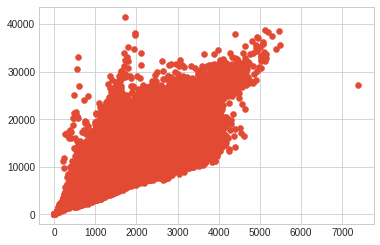

In [0]:
plt.scatter(train.Customers,train.Sales)

In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = pd.DataFrame(sc.fit_transform(np.asarray(train)))

In [0]:
train.columns = ['Customers','Sales']

In [0]:
X = np.asarray(train)
X.shape

(814204, 2)

### The elbow technique calculates sum of squares for each number of cluster and it can be visualized using a plot.

Epoch [1]
Epoch [2]
Epoch [3]
Epoch [4]
Epoch [5]
Epoch [6]
Epoch [7]
Epoch [8]
Epoch [9]
Epoch [10]


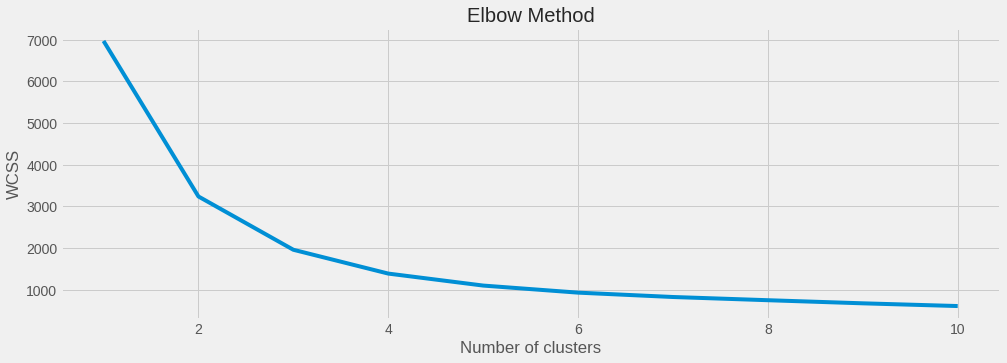

In [0]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    print('Epoch [{}]'.format(i))
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(15,5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Optimal Number of Clusters = 3
### Sum of Squares ~ 2000

In [0]:
Y = np.asarray(data.sample(5000))

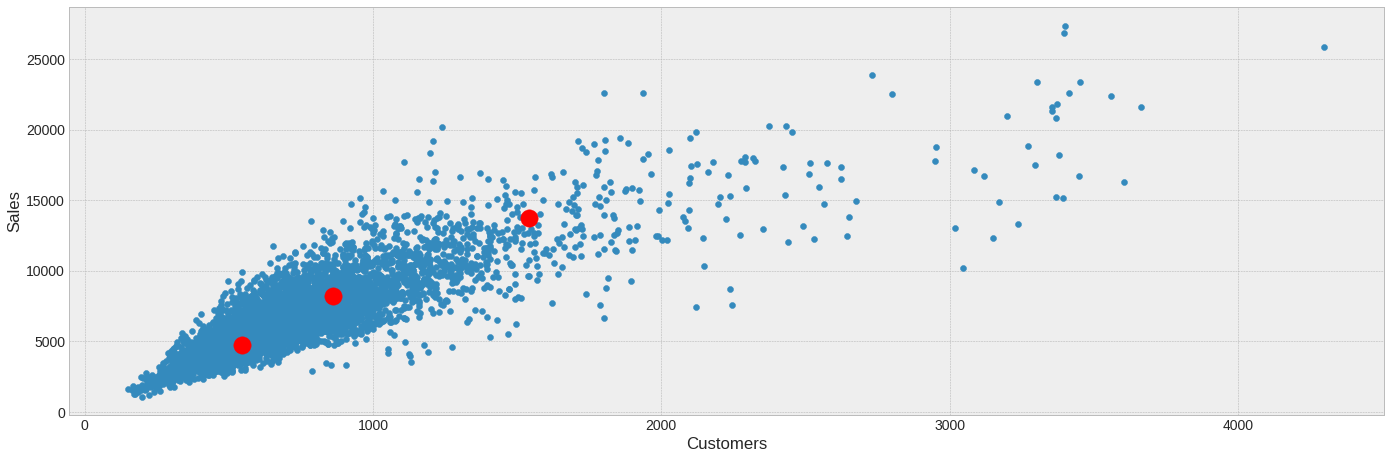

In [0]:
plt.style.use('bmh')
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(Y)
plt.figure(figsize=(21,7))
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.scatter(Y[:,0], Y[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

### From above plot, it can be inferred that there are 3 clusters
### 1. Low Sales and Low Customers
### 2. Low Sales and High Customers
### 3. High Sales and High Customers

### Keeping these clusters in mind , we can filter the complete dataset into 3 seperate datasets and train regression models to get a better fit on the data

## End of Week 3